# CH9

## 9.2 이미지 분할 예제

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-12-23 15:06:25--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-12-23 15:06:25--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-12-23 15:06:26--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [ ]:
import os

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

In [ ]:
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

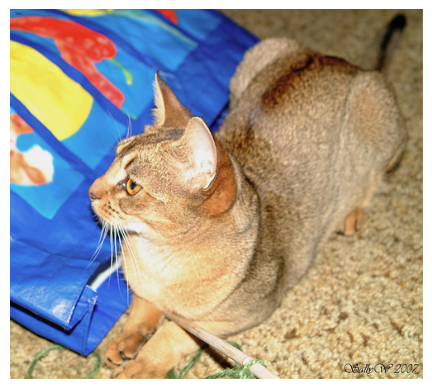

In [ ]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

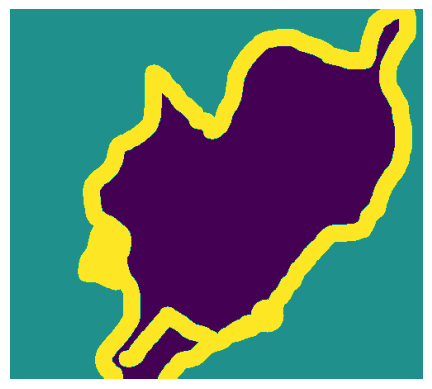

In [ ]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") - 1)*127
  plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
import numpy as np
import random

In [ ]:
img_size = (200, 200) # 입력과 타깃을 모두 200x200으로 변환
num_imgs = len(input_img_paths)

# 입력 경로와 타깃 경로를 동일한 순서로
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1  # 레이블 0, 1, 2 되도록 1 빼기
    return img

# 입력은 3개의 채녈(RGB), 타깃은 정수 레이블을 담은 하나의 채널
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

모델 정의

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)  # 입력 이미지 [0~1] 범위로

    # 패딩이 특성 맵 크기에 영향을 미치지 않도록 padding="same" 지
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    # 각 출력 픽셀을 3개의 범주 중 하나로 분류 위해 3개의 필터, 소프트맥스 활성화 함수 가진 Conv2D로 모델 종료
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

모델 컴파일하고 훈련

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

훈련과 검증 손실을 그래프로

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

에포크 25에서 과대적합 시작 -> 다시 최상의 모델을 로드하여 분할 마스크를 예측

In [ ]:
from tensorflow.keras.utils import array_to_img

In [ ]:
model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

## 9.3 최신 컨브넷 아키텍쳐 패턴

### 9.3.2 잔차 연결

9-1 잔차 연결 의사 코드

In [ ]:
x = ... # 입력 텐서
residual = x  # 원본 입력을 별도로 저장, 잔차
x = block(x)  # 잡음이 있을 수 있지만 괜찮
x = add([x, residual])  # 원본 입력을 층의 출력에 더함, 최종 출력은 항상 원본 입력의 전체 정보 보존

9-2 필터 개수가 변경되는 잔차 블록

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x  # 잔차를 따로 저장
# 잔차블록에 해당하는 층, 출력필터 32->64, 패딩으로 인해 다운샘플링되지 않도록 padding="same"
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
# 잔차는 32개의 필터만 있으므로 1x1 Conv2D를 사용하여 적절한 크기로 투영
residual = layers.Conv2D(64, 1)(residual)
# 블록 출력과 = 잔차의 크기: 더할 수 있음
x = layers.add([x, residual])

9-3 최대 풀링 층을 가진 잔차 블록

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
# 2x2 최대 풀링층을 포함하여 2개의 층으로 구성, 역시나 패딩으로 다운샘플링되지 않도록 padding="same"
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
# 최대 풀링 층으로 인한 다운샘플링에 맞추기 위해 잔차 투영에 strides=2 사용
residual = layers.Conv2D(64, 1, strides=2)(residual)
# 블록 출력 = 잔차의 크기
x = layers.add([x, residual])

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False): # 잔차 연결을 가진 합성곱 블록을 적용하는 유틸리티 함수, 선택적으로 최대풀링 추가
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        # 최대 풀링 사용하면 잔차를 원하는 크기로 투영하기 위해 스트라이드 합성곱 추가
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        # 최대 풀링을 사용하지 않으면 채널 수가 바뀐 경우에만 잔차 투영
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)  # 1st 블록
x = residual_block(x, filters=64, pooling=True)  # 2nd 블록, 블록마다 필터 개수가 증가
x = residual_block(x, filters=128, pooling=False)  # 마지막 블록: 전역 평균 풀링 사용하여 최대풀링 필요X

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 32, 32, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 32, 32, 32)           896       ['rescaling_1[0][0]']         
                                                                                                  
 conv2d_14 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_13[0][0]']           
                                                                                            

### 9.3.3 배치 정규화

9-4 피해야 할 배치 정규화 사용법

In [ ]:
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)

9-5 배치 정규화 사용법: 활성화 층이 마지막에 온다

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)  # 활성화 함수 지정 X
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)  # BatchNormalization층 다음에 활성화층 놓기

### 9.3.5 Xception 유사 모델에 모두 적용하기

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaehyeongkim","key":"680a216f91833c1999382ae7121e6353"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:06<00:00, 130MB/s]
100% 812M/812M [00:06<00:00, 130MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
inputs = keras.Input([180, 180, 3])
x = data_augmentation(inputs)  # 데이터 증식 설정은 이전과 동일
# 분리 합성곱 이면에 있는 "특성 채널은 독립적이다" 라는 가정은 RGB 이미지에는 맞지 않음, 실제로 높은 상관관계, 따라서 Conv2D 그 다음부터 Seperable2D
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# 특성 맵 깊이를 증가시키면서 합성곱 블록을 연속적으로 적용
# 각 블록은 배치 정규화 층을 적용한 2개의 깊이별 분리 합성곱 층과 하나의 최대 풀링 층으로 구성, 잔차연결이 블록마다 추
for size in [32, 64, 128, 256, 512]:
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.BatchNormalization("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.BatchNormalization("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  residual = layers.Conv2D(
      size, 1, strides=2, padding="same", use_bias=False(residual))
  x = layers.add([x, residual])

x = layers.GlobalAveraePooling2D()(x)  # 원래 모델에서는 Dense층 이전에 Flatten 층 사용
x = layers.Dropout(0.5)(x)  # 원래 모델과 마찬가지로 규제를 위해 드롭아웃 층 사용
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 9.4 컨브넷이 학습한 것 해석하기

### 9.4.1 중간 활성화 시각화

In [1]:
from tensorflow import keras

In [3]:
!wget https://github.com/rickiepark/deep-learning-with-python-2nd/raw/main/convnet_from_scratch_with_augmentation.keras

--2023-12-25 16:46:00--  https://github.com/rickiepark/deep-learning-with-python-2nd/raw/main/convnet_from_scratch_with_augmentation.keras
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/deep-learning-with-python-2nd/main/convnet_from_scratch_with_augmentation.keras [following]
--2023-12-25 16:46:00--  https://raw.githubusercontent.com/rickiepark/deep-learning-with-python-2nd/main/convnet_from_scratch_with_augmentation.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7994528 (7.6M) [application/octet-stream]
Saving to: ‘convnet_from_scratch_with_augmentation.keras’

convnet_from_

In [4]:
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

9-6 1개의 이미지 전처리하기

In [5]:
from tensorflow import keras
import numpy as np

In [6]:
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)  # 이미지를 (180, 180, 3) 크기의 float32 넘파이 배열로 변환
    array = np.expand_dims(array, axis=0)  # 배열을 단일 이미지의 '배치'로 변환하기 위해 차원 추가 -> 배열 크기 (1, 180, 180, 3)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 [==============================] - 0s 0us/step


9-7 테스트 이미지 출력하기

In [7]:
import matplotlib.pyplot as plt

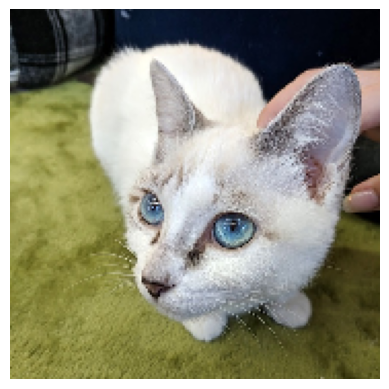

In [8]:
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

9-8 층 활성화를 반환하는 모델 만들기

In [9]:
from tensorflow.keras import layers

In [10]:
layer_outputs = []
layer_names = []
# 모든 Conv2D와 MaxPooling2D층의 출력을 하나의 리스트에 추가
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
# 모델의 입력이 주어졌을 때 층의 출력을 반환하는 모델을 만듦
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

9-9 층 활성화 계산하기

In [11]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 339ms/step


In [12]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


9-10 여섯번째 채널 시각화하기

In [13]:
import matplotlib.pyplot as plt

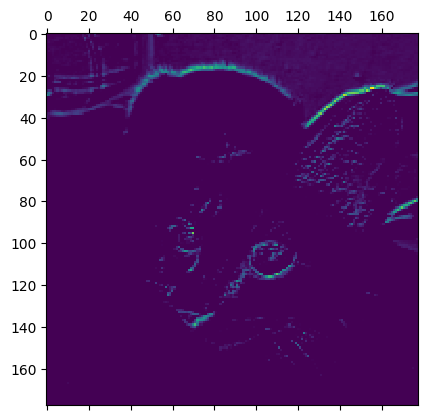

In [14]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")
plt.show()

9-11 모든 층의 활성화에 있는 전체 채널 시각화하기

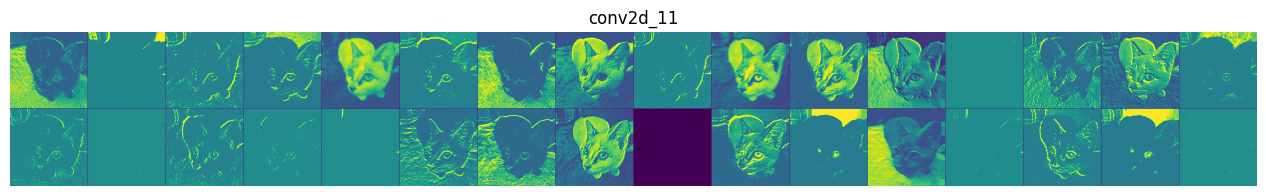

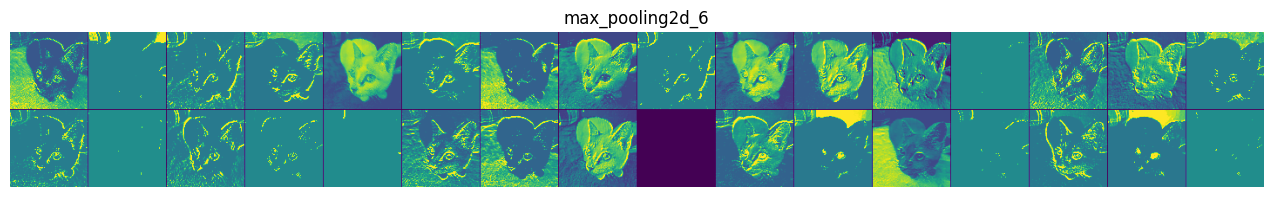

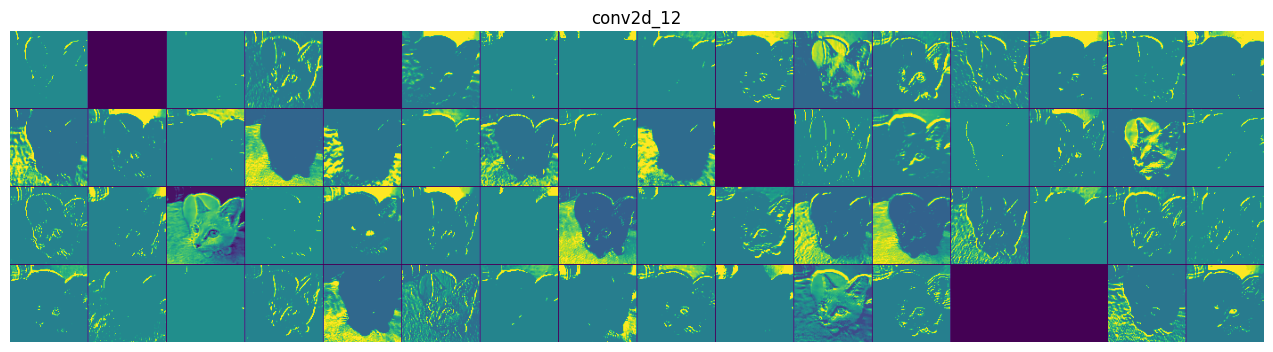

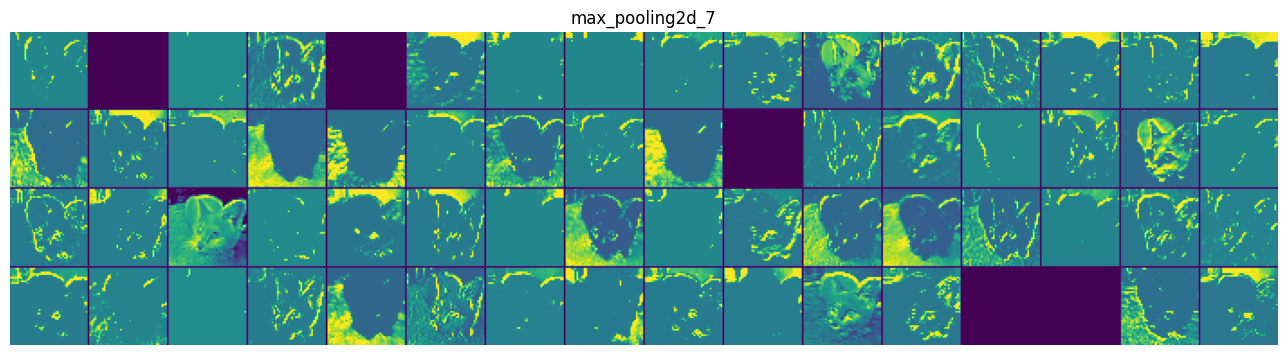

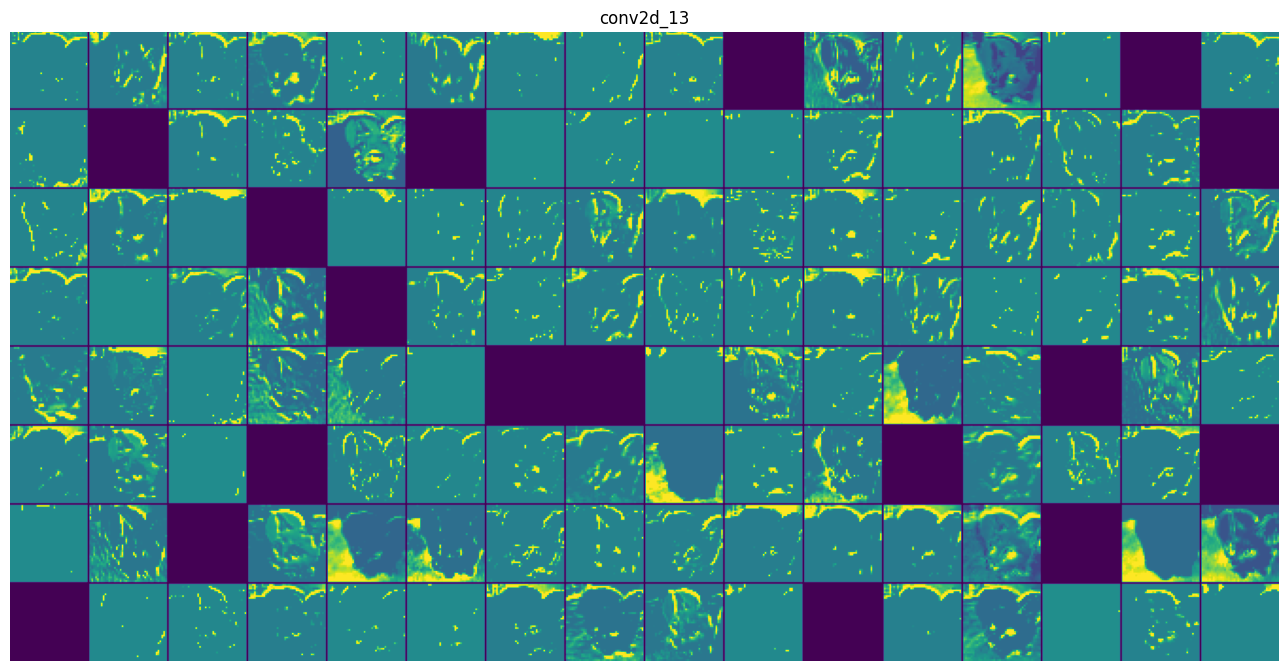

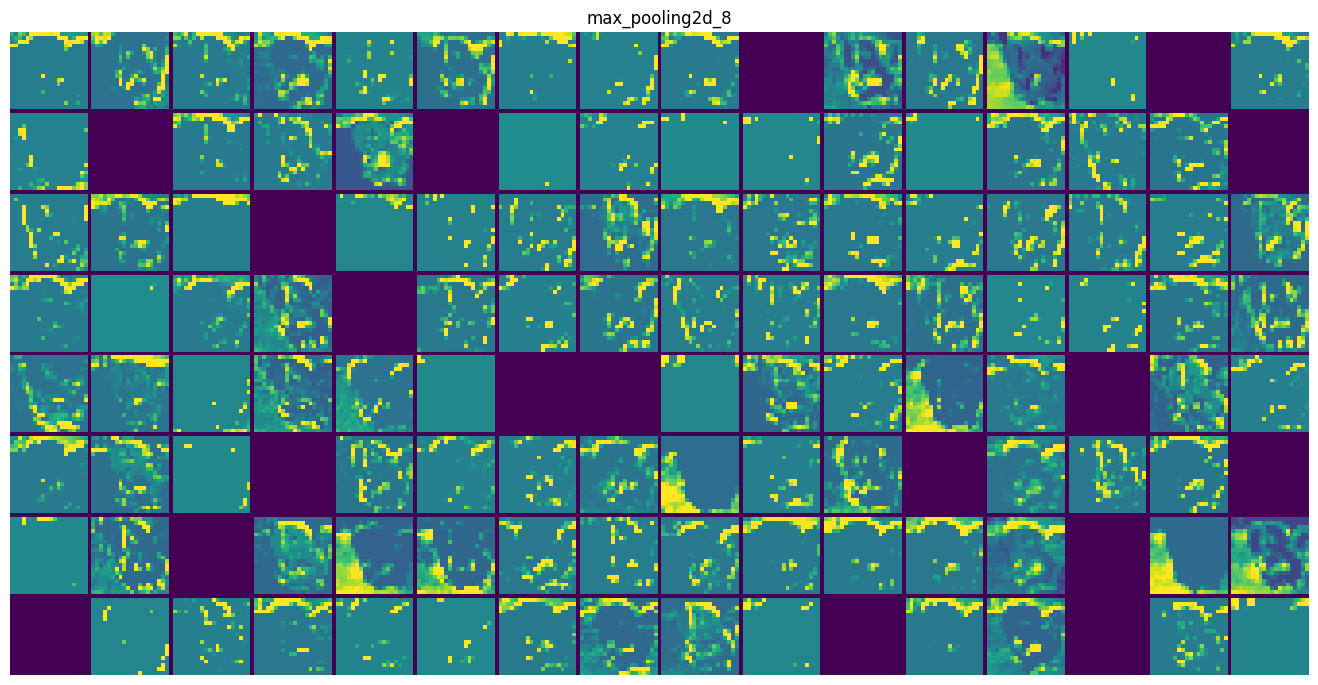

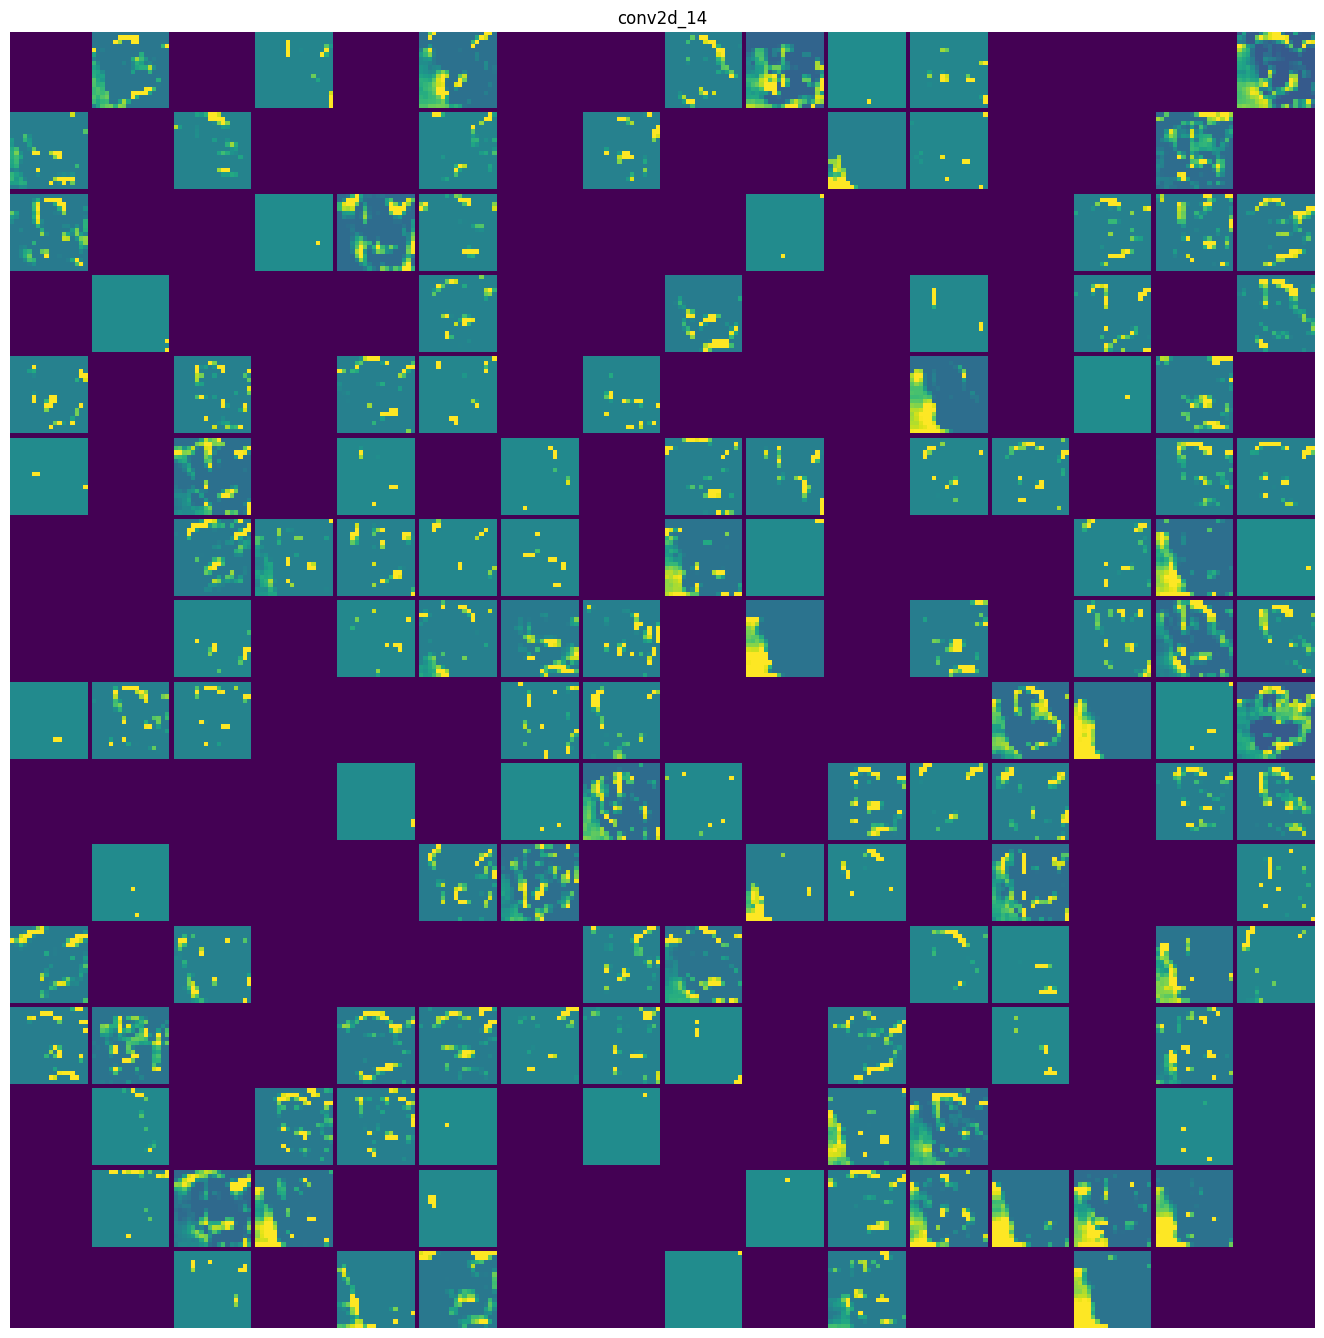

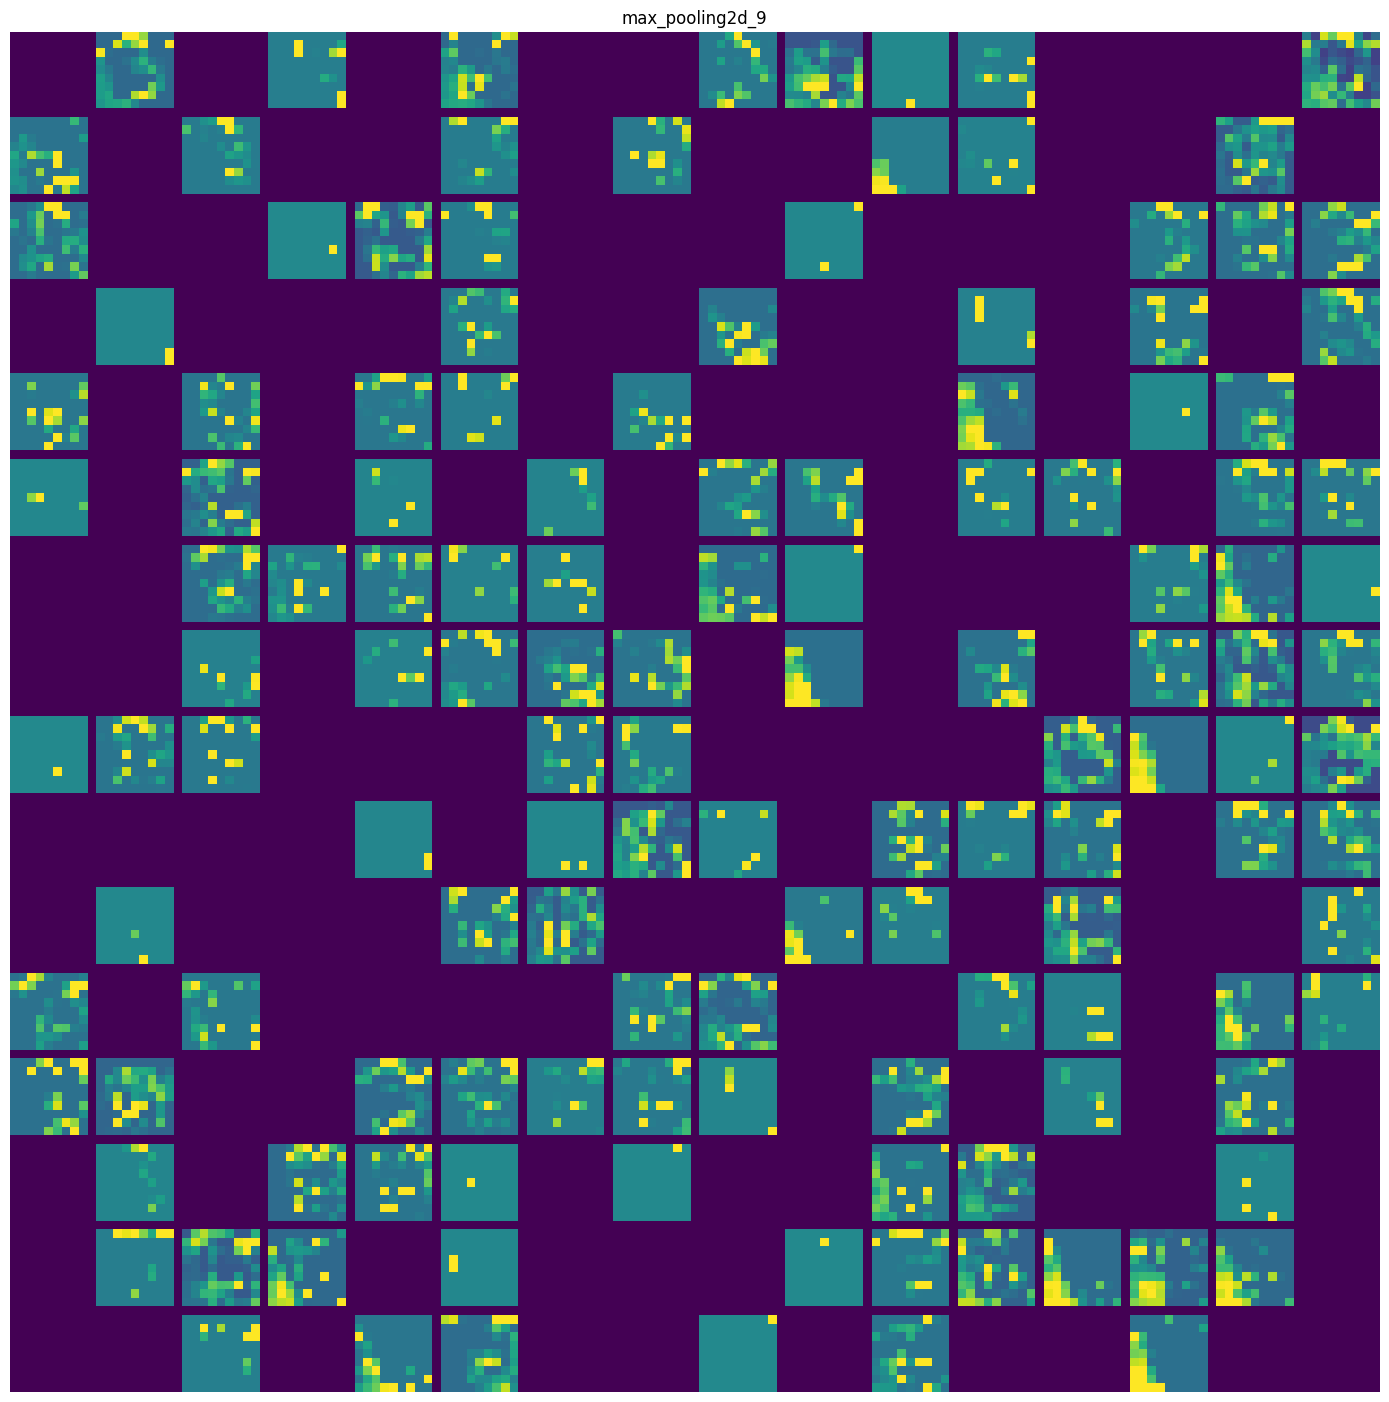

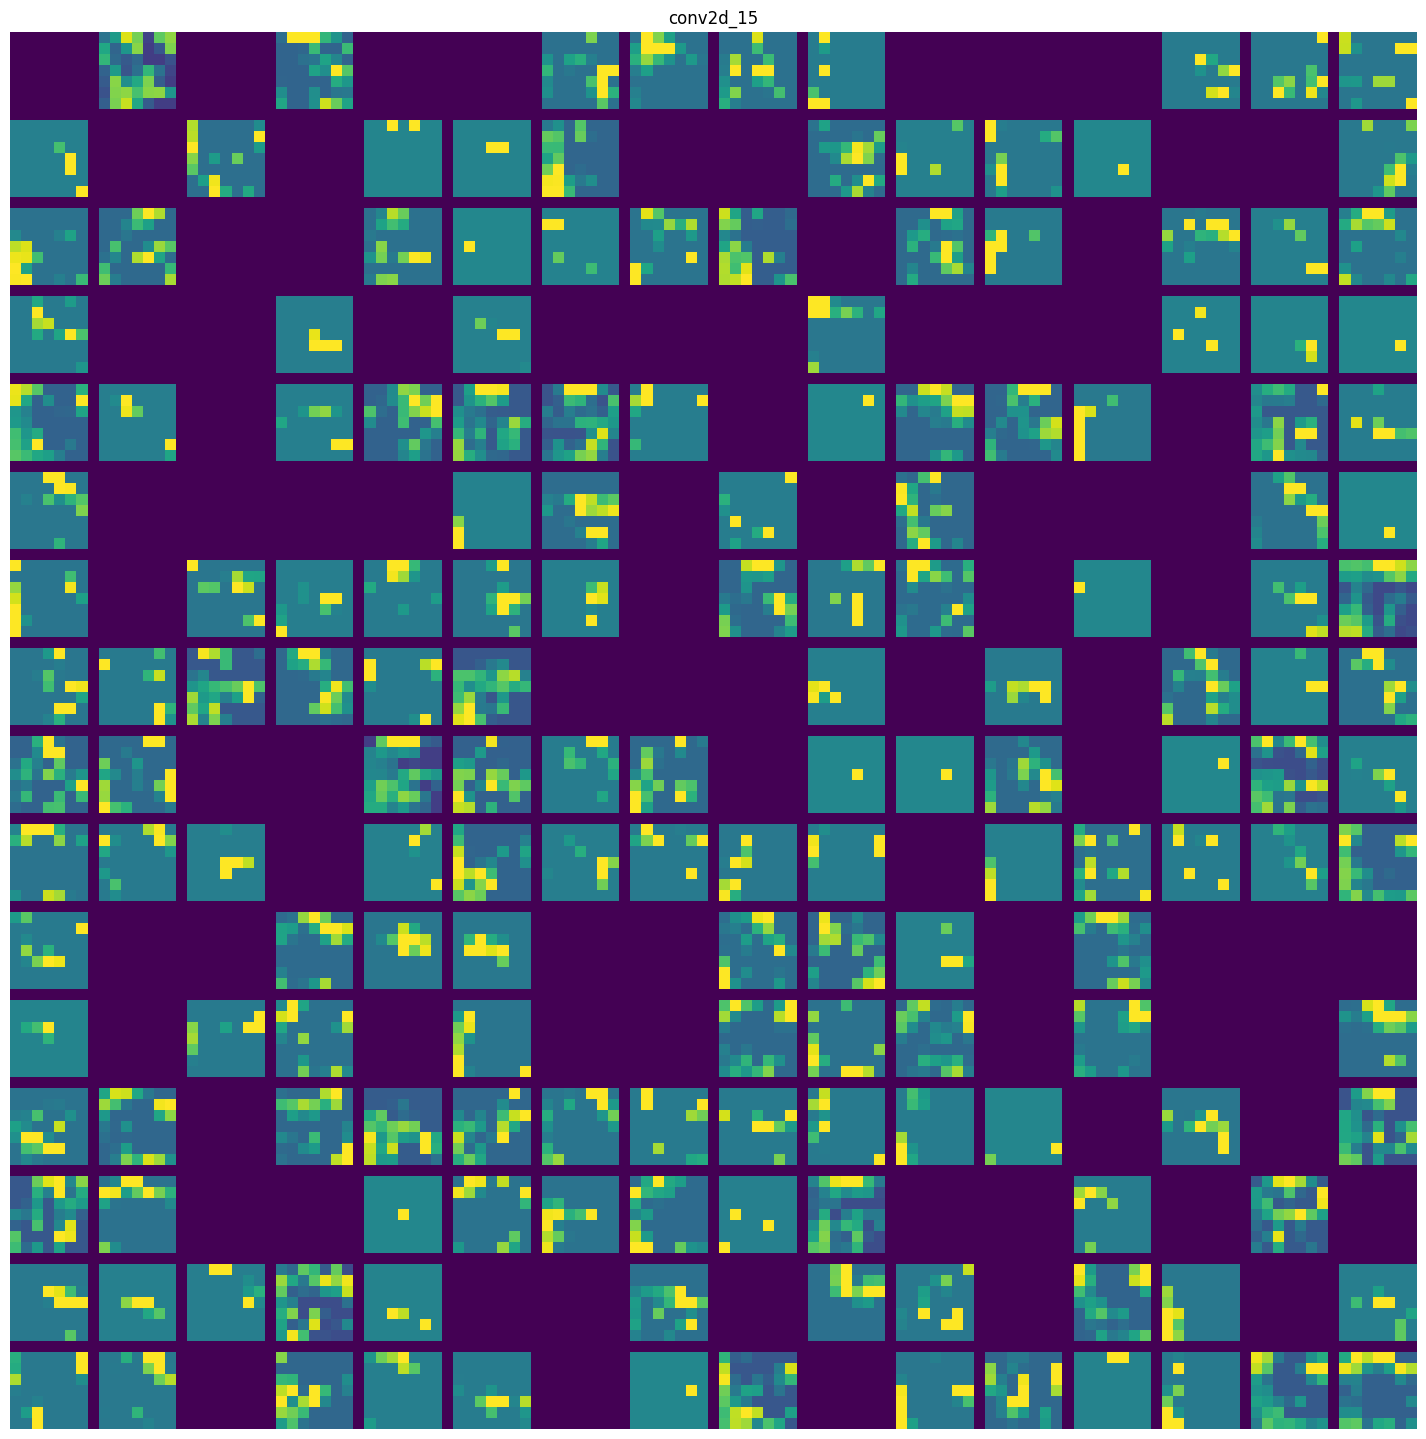

In [15]:
images_per_row = 16
# 활성화, 해당 층 이름에 대해 루프를 순환
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    # 활성화에 있는 모든 채널을 출력하기 위한 빈 그리드 준비
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            # 하나의 채널(또는 특성) 이미지
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            # 빈 그리드에 채널 행렬을 저장
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    # 그리드를 출
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### 9.4.2 컨브넷 필터 시각화하기

9-12 Xception 합성곱 기반 모델 만들기

In [16]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


9-13 Xception에 있는 모든 합성곱 층의 이름 출력하기

In [17]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


9-14 특성 추출 모델 만들기

In [18]:
layer_name = "block3_sepconv1"  # Xception 합성곱 기반에 있는 다른 층의 이름으로 바꿀 수 있다
layer = model.get_layer(name=layer_name)  # 관심 대상인 층의 객체
# model.input과 layer.output을 사용하여 입력 이미지가 주어졌을 때 해당 층의 출력을 반환하는 모델
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

9-15 특성 추출 모델 사용하기

In [19]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [20]:
import tensorflow as tf

In [21]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]  # 손실에 경계 픽셀 제외
    return tf.reduce_mean(filter_activation)  # 필터에 대한 활성화 값의 평균을 반환

9-16 확률적 경사 상승법을 사용한 손실 최대화

In [22]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)  # 현재 이미지가 필터를 얼마나 활성화하는지 나타내는 스칼라 손실 계산
    grads = tape.gradient(loss, image)  # 이미지에 대한 손실의 그레디언트 계산
    grads = tf.math.l2_normalize(grads)  # 그레디언트 정규화 트릭 적용
    image += learning_rate * grads  # 필터를 더 강하게 활성화시키는 방향으로 이미지 조금 이동
    return image  # 업데이트된 이미지 반환

9-17 필터 시각화 생성 함수

In [23]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))  # 랜덤값으로 이미지 텐서 초기화
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)  # 손실함수 최대화하도록 이미지 텐서값 반복적 업데이
    return image[0].numpy()

9-18 텐서를 이미지로 변환하기 위한 유틸리티 함수

In [24]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]  # 부수효과 피하기 위해 경계 픽셀 제외
    return image

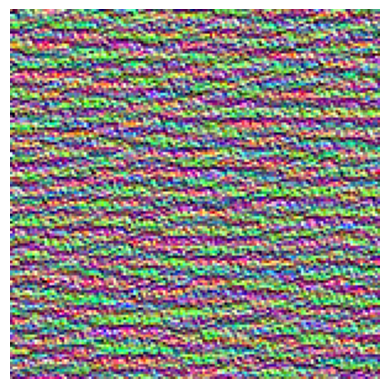

In [25]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

9-19 층에 있는 모든 필터의 응답 패턴에 대한 그리드 생성하기

In [26]:
all_images = []  # 층에 있는 처음 64개의 필터를 시각화하여 저장
for filter_index in range(64):
    print(f"{filter_index}번 필터 처리중")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5  # 필터 시각화를 출력할 빈 이미지를 준비
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):  # 저장된 필터로 이미지 채우기
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(  # 이미지를 디스크에 저장
    f"filters_for_layer_{layer_name}.png", stitched_filters)

0번 필터 처리중
1번 필터 처리중
2번 필터 처리중
3번 필터 처리중
4번 필터 처리중
5번 필터 처리중
6번 필터 처리중
7번 필터 처리중
8번 필터 처리중
9번 필터 처리중
10번 필터 처리중
11번 필터 처리중
12번 필터 처리중
13번 필터 처리중
14번 필터 처리중
15번 필터 처리중
16번 필터 처리중
17번 필터 처리중
18번 필터 처리중
19번 필터 처리중
20번 필터 처리중
21번 필터 처리중
22번 필터 처리중
23번 필터 처리중
24번 필터 처리중
25번 필터 처리중
26번 필터 처리중
27번 필터 처리중
28번 필터 처리중
29번 필터 처리중
30번 필터 처리중
31번 필터 처리중
32번 필터 처리중
33번 필터 처리중
34번 필터 처리중
35번 필터 처리중
36번 필터 처리중
37번 필터 처리중
38번 필터 처리중
39번 필터 처리중
40번 필터 처리중
41번 필터 처리중
42번 필터 처리중
43번 필터 처리중
44번 필터 처리중
45번 필터 처리중
46번 필터 처리중
47번 필터 처리중
48번 필터 처리중
49번 필터 처리중
50번 필터 처리중
51번 필터 처리중
52번 필터 처리중
53번 필터 처리중
54번 필터 처리중
55번 필터 처리중
56번 필터 처리중
57번 필터 처리중
58번 필터 처리중
59번 필터 처리중
60번 필터 처리중
61번 필터 처리중
62번 필터 처리중
63번 필터 처리중


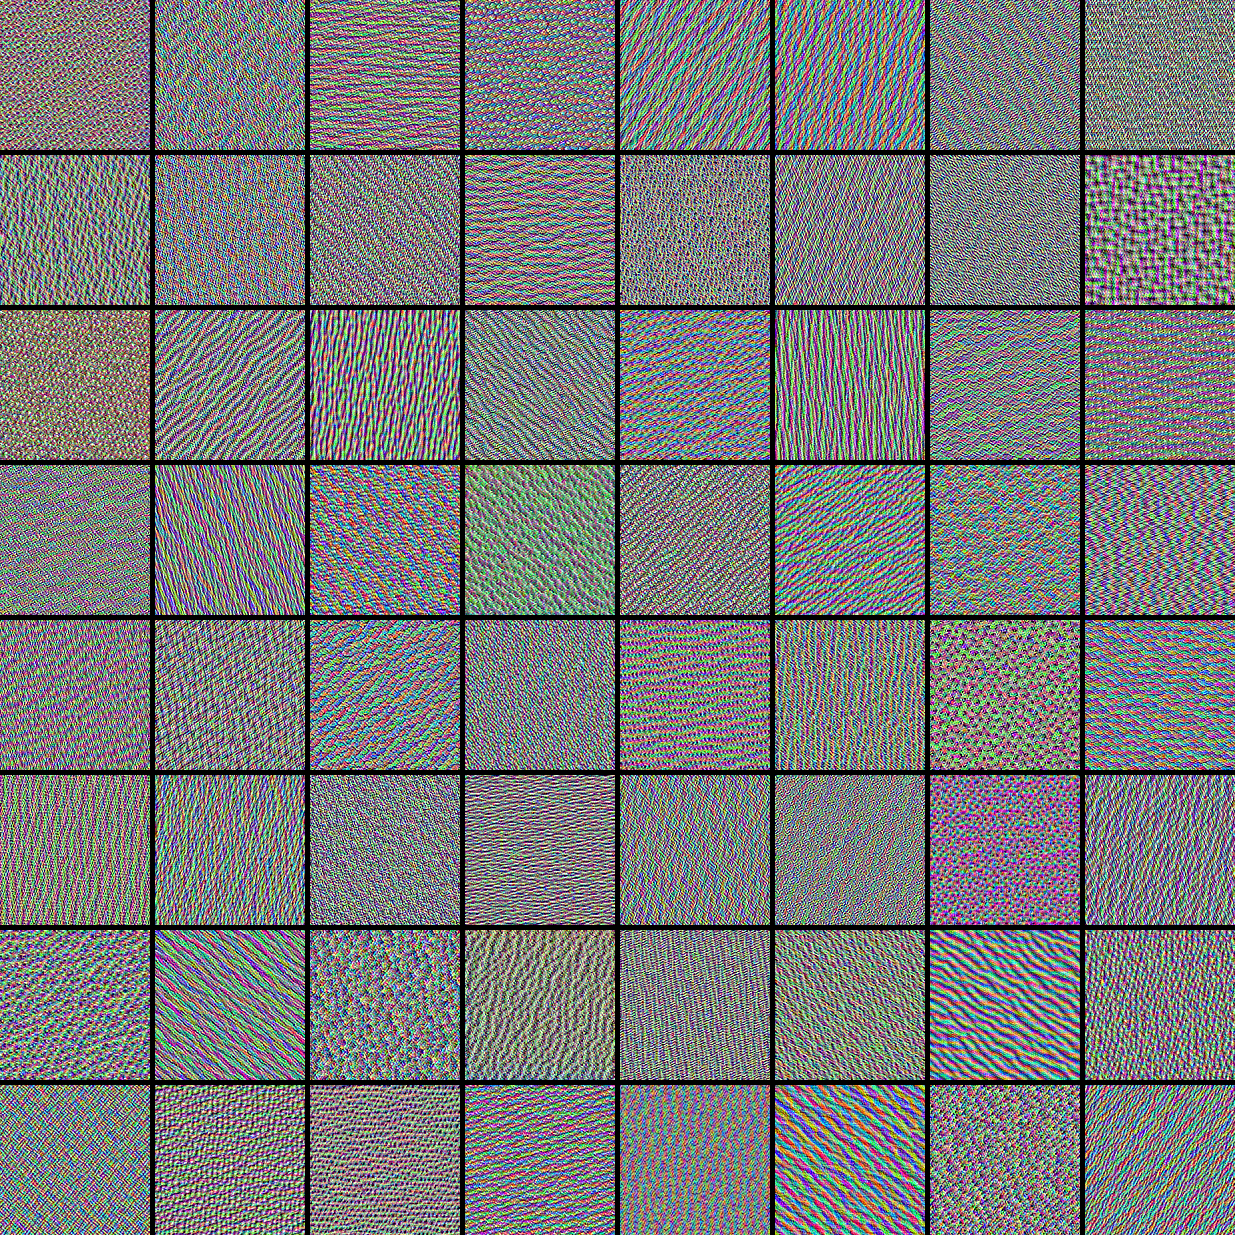

In [27]:
from IPython.display import Image

Image(f"filters_for_layer_{layer_name}.png")

### 9.4.3 클래스 활성화의 히트맵 시각화하기

9-20 사전 훈련된 가중치로 Xception 네트워크 로드하기

In [28]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 2s 0us/step


9-21 Xception 모델에 맞게 입력 이미지 전처리하기

In [29]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size) # 299x299 크기의 PIL 이미지 반환
    array = keras.utils.img_to_array(img)  # (299, 299, 3) 크기의 넘파이 배열 반환
    array = np.expand_dims(array, axis=0)  # (1, 299, 299, 3) 배치로 변환 위해 차원 추가
    array = keras.applications.xception.preprocess_input(array)  # 배치를 전처리(채널별 컬러 정규화)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 [==============================] - 0s 0us/step


In [30]:
# 이미지에서 사전 훈련된 네트워크를 실해앟고 예측벡터를 이해하기 쉽게 디코
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.86993986), ('n01871265', 'tusker', 0.07695617), ('n02504013', 'Indian_elephant', 0.023541749)]


In [31]:
np.argmax(preds[0])

386

9-22 마지막 합성곱 출력을 반환하는 모델 만들기

In [32]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

9-23 마지막 합성곱 출력 위에 있는 분류기에 적용하기 위한 모델 만들기

In [33]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

9-24 최상위 예측 클래스의 그레디언트 계산하기

In [34]:
with tf.GradientTape() as tape:
    # 마지막 합성곱 층의 활성화를 계산하고 그레디언트 테이프로 감시
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # 최상위 예측 클래스에 해당하는 활성화 채널을 추출
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# 마지막 합성곱 층의 출력 특성 맵에 대한 최상위 예측 클래스의 그레디언트를 계산
grads = tape.gradient(top_class_channel, last_conv_layer_output)

9-25 그레디언트를 평균하고 채널 중요도 가중치 적용하기

In [35]:
# 아래 벡터의 각 원소: 어떤 채널에 대한 그레디언트의 편균 강도, 최상위 예측 클래스에 대한 각 채널의 중요도를 정량화
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
# 마지막 합성곱 층의 출력에 있는 각 채널에 채널의 중요도 곱하기
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
# 만들어진 특성맵을 채널별로 평균하면 클래스 활성화 히트맵
heatmap = np.mean(last_conv_layer_output, axis=-1)

9-25 히트맵 후처리하기

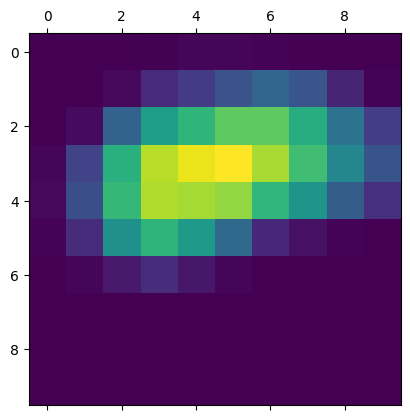

In [36]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

9-26 원본 이미지 위에 히트맵 그리기

In [37]:
import matplotlib.cm as cm

In [38]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-38-38cc72aec6dd>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


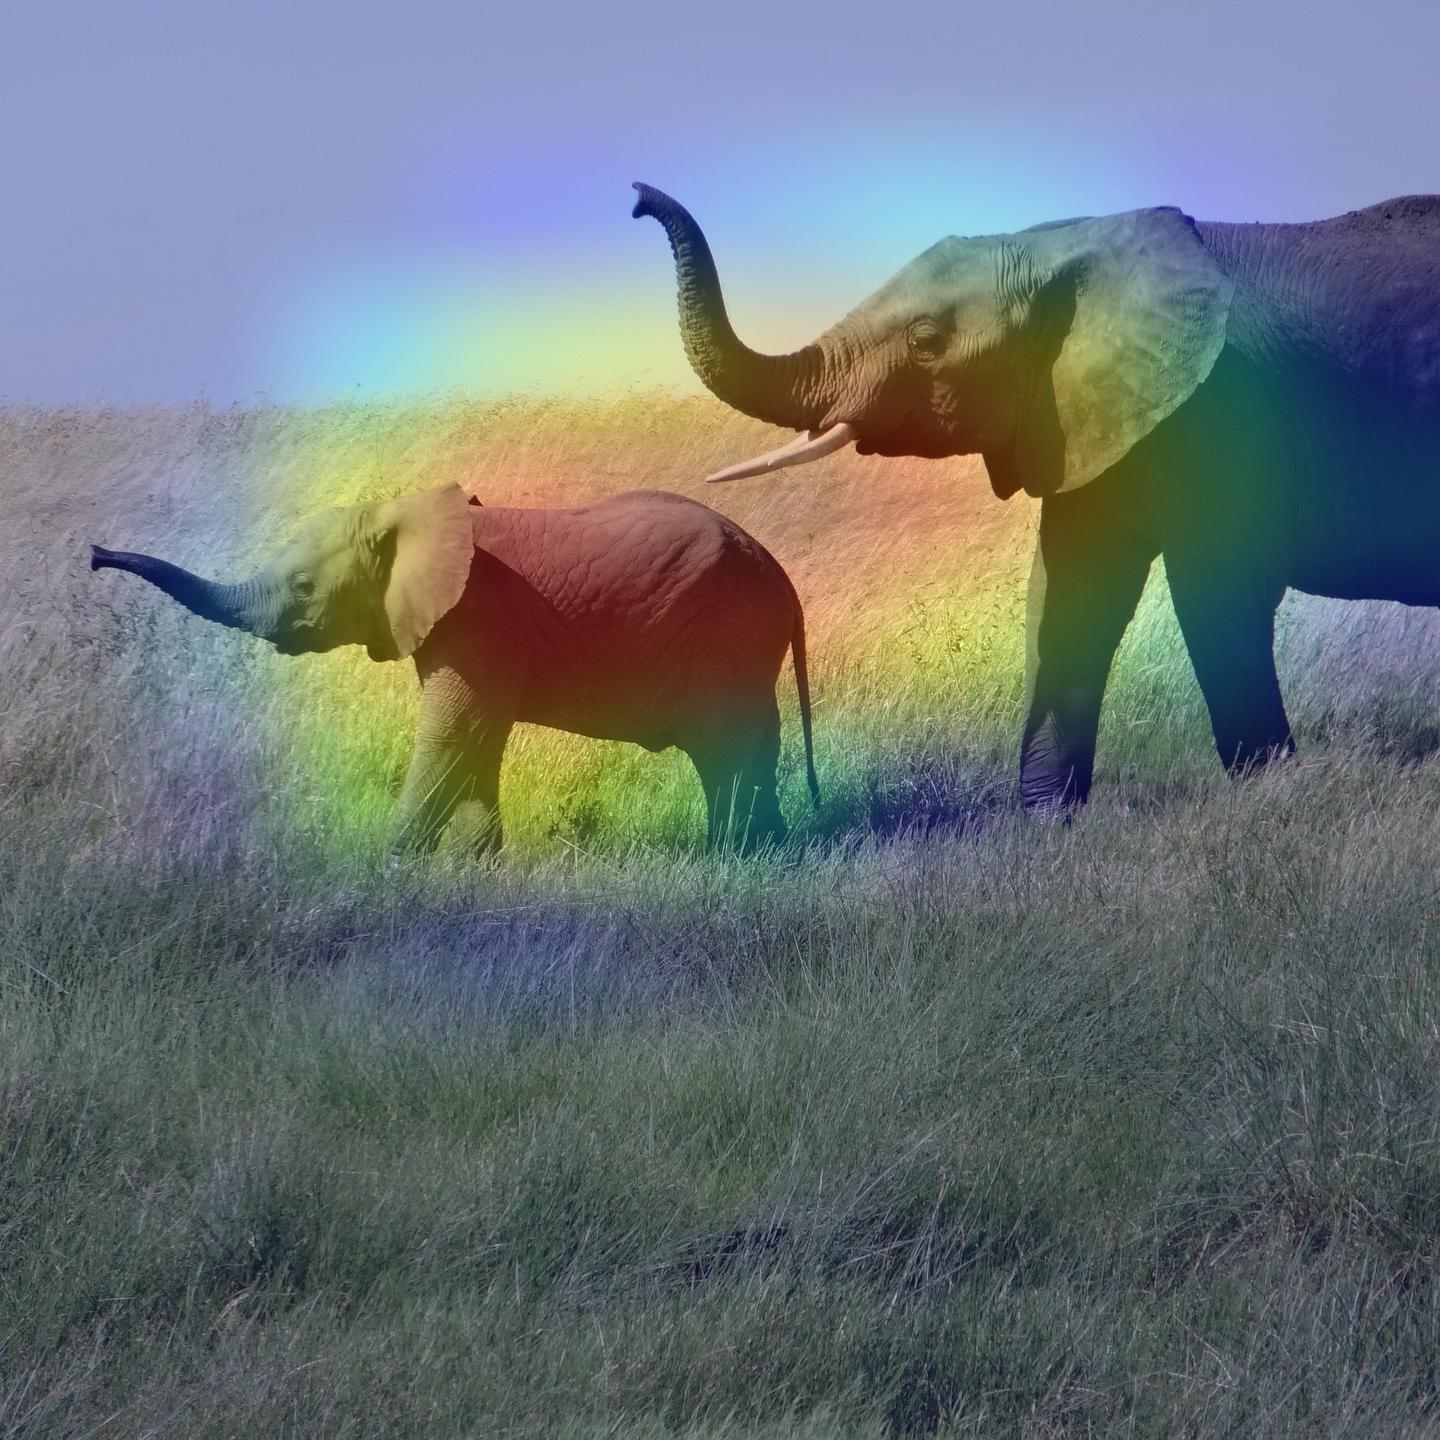

In [39]:
Image("elephant_cam.jpg")